# 경진대회 이해
## 링크
- [Predict Future Sales
](https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales)
## 데이터
- sales_train.csv - 훈련 세트. 2013년 1월부터 2015년 10월까지의 일일 기록 데이터입니다.
- items.csv - 제품에 대한 부가 정보입니다.
- item_categories.csv - 제품 카테고리에 대한 부가 정보입니다.
- shops.csv - 가게에 대한 부가 정보입니다.
- test.csv - 테스트 세트. 2015년 11월의 가게와 제품 판매량을 예측해야 합니다.
- sample_submission.csv - 올바른 형식으로 제출할 샘플 제출 파일입니다.
## 목적
-  1C Company가 제공한 매일의 판매 데이터를 사용하여 
- 다음 달의 각 제품과 매장별 총 매출을 예측하는 것을 목표
- 따라서 이 데이터를 활용하여 예측 모델을 만들고 성능을 평가하는 것이 이 경진대회의 주요한 목적
## 평가
- 이 대회에서는 모델의 예측값과 실제값 간의 평균 제곱근 오차(RMSE)로 성능을 평가합니다. 
- 실제 목표값이 [0, 20] 범위로 제한되어 있기 때문에, 이 범위를 벗어나는 예측값에 대해서는 [0, 20] 범위로 클리핑(clipping)을 하여 평가
    - 예를 들어, 모델이 25를 예측했을 경우, 이 값은 20으로 클리핑됩니다. 

# 탐색적 데이터 분석

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/restful3/datasets/kaggle/predict-future-sales/"
sales_train = pd.read_csv(data_path+"sales_train.csv")
shops = pd.read_csv(data_path+"shops.csv")
items = pd.read_csv(data_path+"items.csv")
item_categories = pd.read_csv(data_path+"item_categories.csv")
test = pd.read_csv(data_path+"test.csv")
sample_submission = pd.read_csv(data_path+"sample_submission.csv")

## 데이터 둘러보기

### sales_train 데이터

In [13]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


- 월간 판매량을 구해야 하니, date 열은 삭제
- item_cnt_day는 일간 판매량, date_block_num를 활용하여 월간 판매량을 구할 것

In [14]:
# 데이터의 수가 1690785개 이상이면 결측값의 개수를 출력하지 않음, 
# show_counts 옵션을 True로 줘야
sales_train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   date            2935849 non-null  object 
 1   date_block_num  2935849 non-null  int64  
 2   shop_id         2935849 non-null  int64  
 3   item_id         2935849 non-null  int64  
 4   item_price      2935849 non-null  float64
 5   item_cnt_day    2935849 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


### shops 데이터

In [15]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [16]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


### items 데이터

In [17]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [18]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


### item_categories 데이터

In [19]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [20]:
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [21]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


### test 데이터

In [22]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 데이터 병합

In [23]:
train = sales_train.merge(shops, on='shop_id', how='left')
train = train.merge(items, on='item_id', how='left')
train = train.merge(item_categories, on='item_category_id', how='left')

In [24]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства


### 피처 요약표 만들기

In [27]:
def resumetable(df):
    print(f'데이터셋 형상:', df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피처'})
    summary['결측값 개수'] = df.isnull().sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['첫 번째 값'] = df.loc[0].values
    summary['두 번째 값'] = df.loc[1].values    
    
    return summary

In [28]:
resumetable(train)

데이터셋 형상: (2935849, 10)


,피처,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,date,object,0,1034,02.01.2013,03.01.2013
1,date_block_num,int64,0,34,0,0
2,shop_id,int64,0,60,59,25
3,item_id,int64,0,21807,22154,2552
4,item_price,float64,0,19993,999.0,899.0
5,item_cnt_day,float64,0,198,1.0,1.0
6,shop_name,object,0,60,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум"""
7,item_name,object,0,21807,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP
8,item_category_id,int64,0,84,37,58
9,item_category_name,object,0,84,Кино - Blu-Ray,Музыка - Винил


## 데이터 시각화

### 일일 판매량

In [29]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

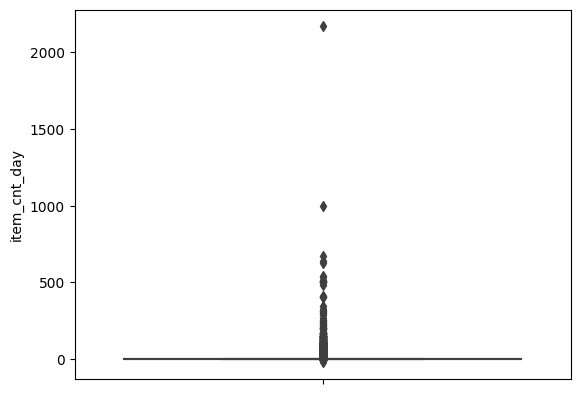

In [30]:
sns.boxplot(y='item_cnt_day', data=train);

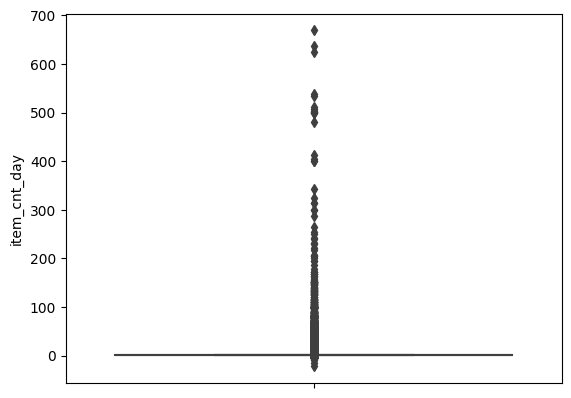

In [38]:
sns.boxplot(y='item_cnt_day', data=train[train['item_cnt_day']<1000]);

### 판매가(상품 가격

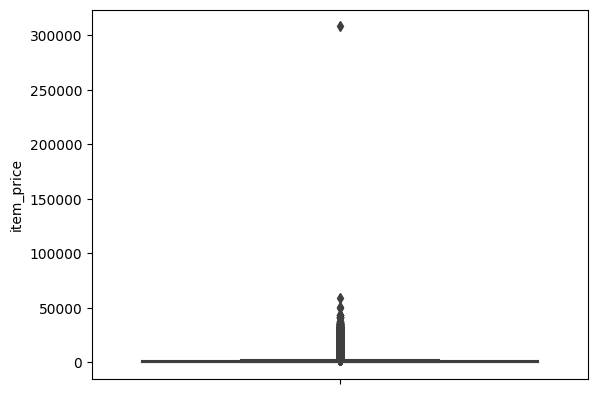

In [33]:
sns.boxplot(y='item_price', data=train);

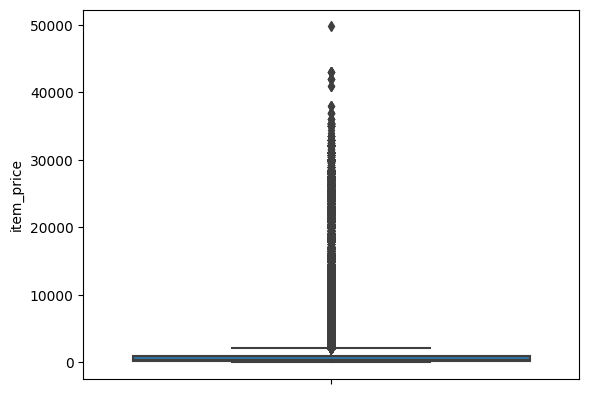

In [35]:
sns.boxplot(y='item_price', data=train[train['item_price']<50000]);

### 그룹화

In [39]:
group = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})

In [40]:
group.reset_index()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0
5,5,125381.0
6,6,116966.0
7,7,125291.0
8,8,133332.0
9,9,127541.0


### 월별 판매량

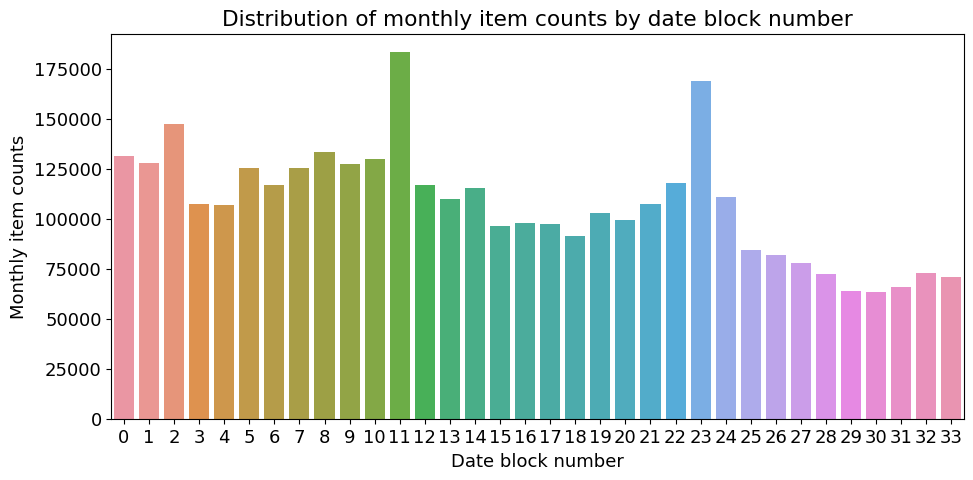

In [43]:
mpl.rc('font', size=13)
fig, ax = plt.subplots(figsize=((11, 5)))

group_month_sum = train.groupby('date_block_num').agg({'item_cnt_day':'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_day', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
      xlabel = 'Date block number', ylabel='Monthly item counts');

### 상품분류별 판매량

In [44]:
train['item_category_id'].nunique()

84

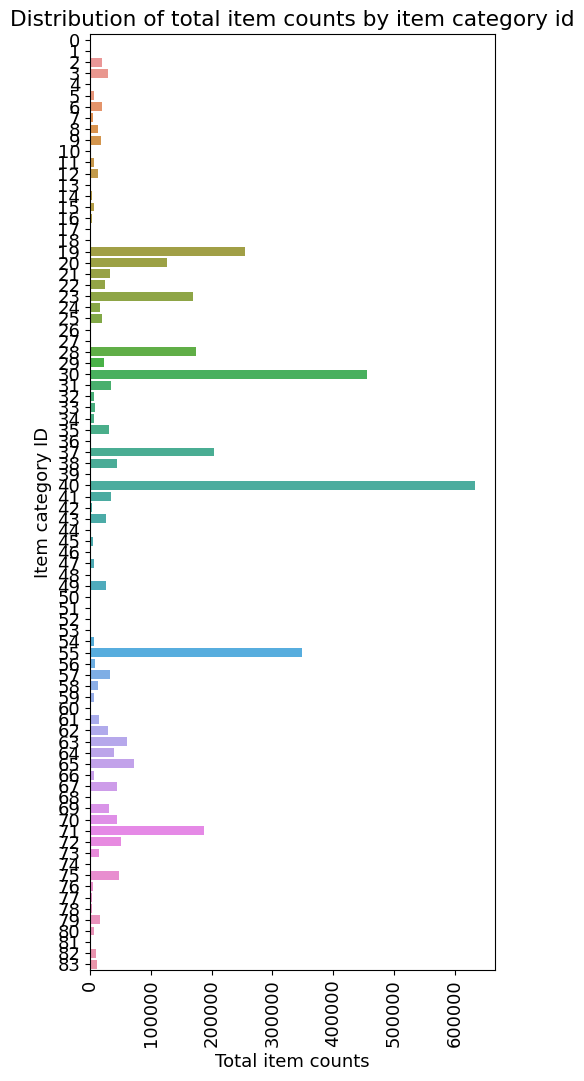

In [53]:
mpl.rc('font', size=13)
fig, ax = plt.subplots(figsize=((5, 11)))

group_cat_sum = train.groupby('item_category_id').agg({'item_cnt_day':'sum'})
group_month_sum = group_cat_sum.reset_index()

sns.barplot(y='item_category_id', x='item_cnt_day', data=group_month_sum, orient='h')
ax.set(title='Distribution of total item counts by item category id',
      ylabel = 'Item category ID', xlabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)
plt.tight_layout();

### 상점별 판매량

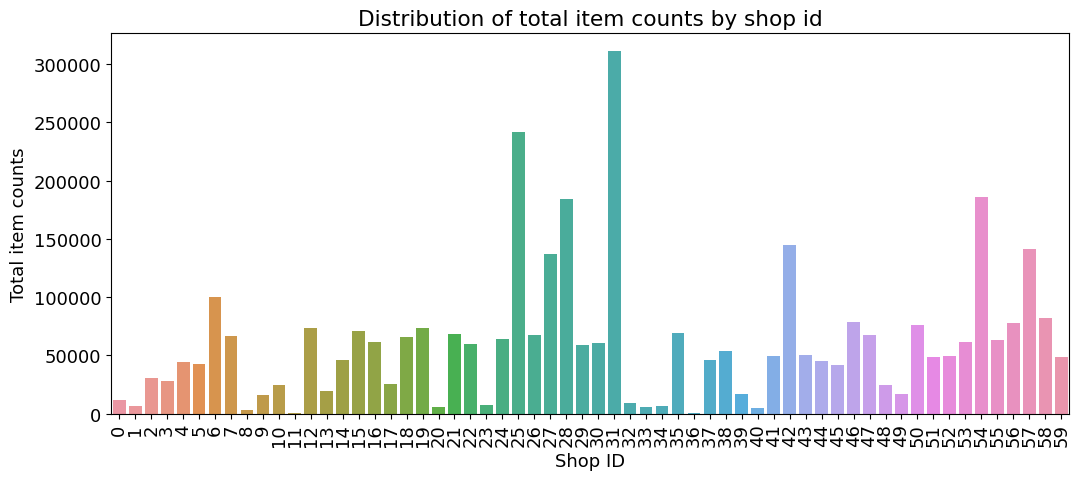

In [56]:
mpl.rc('font', size=13)
fig, ax = plt.subplots(figsize=((11, 5)))

group_shop_sum = train.groupby('shop_id').agg({'item_cnt_day':'sum'})
group_shop_sum = group_shop_sum.reset_index()

sns.barplot(x='shop_id', y='item_cnt_day', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
      xlabel = 'Shop ID', ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)
plt.tight_layout();

# 분석 정리 및 모델링 전략

## 분석 정리

- 대회의 타깃값 규정 상, 판매량 관런 피처의 값은 모두 0 ~ 20 사이로 제한
- 시계열 데이터, 데이터 순서 꼭 지켜야
    - OOF 예측 등 데이터 순서가 무시되는 기법은 사용 불가
    - 검증 데이터는 훈련 데이터 중 가장 최근 1개월치 사용
- 타깃값 : 월별 판매량 예측, 주어진 데이터는 일별 데이터, 같은 달의 일별 판매량을 합쳐야
- 데이터 병합 : 추가 정보 파일(상점, 상품, 상품 분류)은 각각 ID(상품 ID, 상품분류ID, 상점 ID)기준으로 병합하여 테스트 데이터 만들기
- 다양한 피처 엔지니어링, 메모리 커짐, 메모리 관리 필요
- 파생 피처 추가 : 상점명, 상품분류명 등 첫 단어가 각각 도시와 대분류
- 피처 제거 : 월별 판매량만 구하면 되니 date 피처 불필요
- 피처 제거 : 상점 ID, 상품 ID, 상품분류 ID 는 각각 상점명, 상품명, 상품분류명과 1:1 매칭되어 하나만 필요
- 이사잋 제거 : 일별 판매량과 판매가에는 값이 과한 데이터(이상치) 존재
- 모든 데이터에는 결측치 없음

## 모델링 전략

- 이번 장은 피처 엔지니어링 위주
- 베이스 모델 : LightGBM
    - 피처 엔지니어링 : 피처명 한글화, 데이터 다운캐스팅, 데이터 조합 생성, 타깃값 추가
- 성능개선 : LightGBM 유지
    - 피처 엔지니어링 : 이상치 제거, 전처리 등 다양한 파생 피처 추가, 인코딩, 결측값 처리

# 베이스라인 모델

In [9]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

data_path = "/home/restful3/datasets/kaggle/predict-future-sales/"
sales_train = pd.read_csv(data_path+"sales_train.csv")
shops = pd.read_csv(data_path+"shops.csv")
items = pd.read_csv(data_path+"items.csv")
item_categories = pd.read_csv(data_path+"item_categories.csv")
test = pd.read_csv(data_path+"test.csv")
submission = pd.read_csv(data_path+"sample_submission.csv")

## 피처 엔지니어링 1 : 피처명 한글화

- 데이터가 많아, 이해를 위해 한글화

In [10]:
sales_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')

In [11]:
sales_train = sales_train.rename(columns={
                                    'date' : '날짜', 
                                    'date_block_num':'월ID', 
                                    'shop_id':'상점ID', 
                                    'item_id':'상품ID', 
                                    'item_price':'판매가',
                                    'item_cnt_day' : '판매량'
                                })
sales_train.head()

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [12]:
shops = shops.rename(columns={'shop_name':'상점명', 'shop_id':'상점ID'})
shops.head()

,상점명,상점ID
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [13]:
items = items.rename(columns={'item_name':'상품명',
                             'item_id':'상품ID', 
                             'item_category_id':'상품분류ID'})
items.head()

,상품명,상품ID,상품분류ID
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [14]:
item_categories = item_categories.rename(columns={
    'item_category_name':'상품분류명', 'item_category_id':'상품분류ID'
})
item_categories.head()

,상품분류명,상품분류ID
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
test = test.rename(columns={'shop_id':'상점ID', 'item_id':'상품ID'})
test.head()

,ID,상점ID,상품ID
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


##  피처 엔지니어링 2 : 데이터 다운캐스팅

In [16]:
def downcast(df, verbose= True):
    start_mem = df.memory_usage().sum()/1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum()/1024**2
    if verbose:
        print(f'{100*(start_mem - end_mem)/start_mem}% 압축됨')
        
    return df

In [17]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   날짜      object 
 1   월ID     int64  
 2   상점ID    int64  
 3   상품ID    int64  
 4   판매가     float64
 5   판매량     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   ID      214200 non-null  int64
 1   상점ID    214200 non-null  int64
 2   상품ID    214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [19]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

54.1666174664819% 압축됨
38.60294117647059% 압축됨
54.153639178666985% 압축됨
39.94565217391305% 압축됨
70.83156970881522% 압축됨


## 피처 엔지니어링 3 : 데이터 조합 생성

In [20]:
from itertools import product
from tqdm import tqdm

train = []

for i in tqdm(sales_train['월ID'].unique()):
    all_shop = sales_train.loc[sales_train['월ID'] == i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID'] == i, '상품ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

100%|███████████████████████████████████████████| 34/34 [00:03<00:00,  8.71it/s]


In [21]:
idx_features = ['월ID', '상점ID', '상품ID']
train = pd.DataFrame(np.vstack(train), columns=idx_features)
train

,월ID,상점ID,상품ID
0,0,59,22154
1,0,59,2552
2,0,59,2554
3,0,59,2555
4,0,59,2564
...,...,...,...
10913845,33,21,7635
10913846,33,21,7638
10913847,33,21,7640
10913848,33,21,7632


## 피처 엔지니어링 4 : 타깃값(월간 판매량) 추가

In [22]:
idx_features

['월ID', '상점ID', '상품ID']

In [23]:
group = sales_train.groupby(idx_features).agg({'판매량':'sum'})

In [24]:
group

판매량
월ID 상점ID 상품ID      
0   0    32       6
         33       3
         35       1
         43       1
         51       2
...             ...
33  59   22087    6
         22088    2
         22091    1
         22100    1
         22102    1

[1609124 rows x 1 columns]

In [25]:
group = group.reset_index()
group

,월ID,상점ID,상품ID,판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [26]:
group = group.rename(columns={'판매량':'월간 판매량'})
group

,월ID,상점ID,상품ID,월간 판매량
0,0,0,32,6
1,0,0,33,3
2,0,0,35,1
3,0,0,43,1
4,0,0,51,2
...,...,...,...,...
1609119,33,59,22087,6
1609120,33,59,22088,2
1609121,33,59,22091,1
1609122,33,59,22100,1


In [27]:
train = train.merge(group, on=idx_features, how='left')
train

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,NaN
2,0,59,2554,NaN
3,0,59,2555,NaN
4,0,59,2564,NaN
...,...,...,...,...
10913845,33,21,7635,NaN
10913846,33,21,7638,NaN
10913847,33,21,7640,NaN
10913848,33,21,7632,NaN


In [28]:
import gc

del group
gc.collect()

446

## 피처 엔지니어링 5 : 테스트 데이터 이어붙이기

In [29]:
sales_train

,날짜,월ID,상점ID,상품ID,판매가,판매량
0,02.01.2013,0,59,22154,999.00,1
1,03.01.2013,0,25,2552,899.00,1
2,05.01.2013,0,25,2552,899.00,-1
3,06.01.2013,0,25,2554,1709.05,1
4,15.01.2013,0,25,2555,1099.00,1
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1
2935845,09.10.2015,33,25,7460,299.00,1
2935846,14.10.2015,33,25,7459,349.00,1
2935847,22.10.2015,33,25,7440,299.00,1


In [30]:
test['월ID'] = 34

In [31]:
all_data = pd.concat([train, test.drop("ID", axis=1)], 
                    ignore_index=True, keys=idx_features)

In [32]:
all_data = all_data.fillna(0)
all_data

,월ID,상점ID,상품ID,월간 판매량
0,0,59,22154,1.0
1,0,59,2552,0.0
2,0,59,2554,0.0
3,0,59,2555,0.0
4,0,59,2564,0.0
...,...,...,...,...
11128045,34,45,18454,0.0
11128046,34,45,16188,0.0
11128047,34,45,15757,0.0
11128048,34,45,19648,0.0


In [33]:
import pandas as pd

df1 = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
df2 = pd.DataFrame({'A': [7, 8, 9], 'B': [10, 11, 12]})

In [34]:
concatenated_df = pd.concat([df1, df2], keys=['X', 'Y'], 
                            ignore_index=False)

print(concatenated_df)

     A   B
X 0  1   4
  1  2   5
  2  3   6
Y 0  7  10
  1  8  11
  2  9  12


In [35]:
concatenated_df = pd.concat([df1, df2], keys=['X', 'Y'], 
                            ignore_index=True)

print(concatenated_df)

   A   B
0  1   4
1  2   5
2  3   6
3  7  10
4  8  11
5  9  12


## 피처 엔지니어링 6 : 나머지 데이터 병합(최종 데이터 생성)

In [36]:
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

In [37]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   월ID     int64  
 1   상점ID    int16  
 2   상품ID    int16  
 3   월간 판매량  float64
 4   상점명     object 
 5   상품명     object 
 6   상품분류ID  int8   
 7   상품분류명   object 
dtypes: float64(1), int16(2), int64(1), int8(1), object(3)
memory usage: 562.5+ MB


In [38]:
all_data = downcast(all_data)

26.41509433962264% 압축됨


In [39]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Data columns (total 8 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   월ID     int8  
 1   상점ID    int8  
 2   상품ID    int16 
 3   월간 판매량  int16 
 4   상점명     object
 5   상품명     object
 6   상품분류ID  int8  
 7   상품분류명   object
dtypes: int16(2), int8(3), object(3)
memory usage: 413.9+ MB


In [40]:
del shops, items, item_categories
gc.collect()

0

In [41]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,상점명,상품명,상품분류ID,상품분류명
0,0,59,22154,1,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,0,59,2552,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,0,59,2554,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
3,0,59,2555,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
4,0,59,2564,0,"Ярославль ТЦ ""Альтаир""",DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео


In [42]:
all_data = all_data.drop(['상점명', '상품명', '상품분류명'], axis=1)

In [43]:
all_data.tail()

,월ID,상점ID,상품ID,월간 판매량,상품분류ID
11128045,34,45,18454,0,55
11128046,34,45,16188,0,64
11128047,34,45,15757,0,55
11128048,34,45,19648,0,40
11128049,34,45,969,0,37


## 피처 엔지니어링 7 : 마무리
- 훈련 데이터 : 2013년 1월 ~ 2015년 9월(월ID = 32) 판매 내역
- 검증 데이터 : 2015년 10월(월ID = 33) 판매 내역
- 테스트 데이터 : 2015년 11월(월ID=34) 판매 내역

In [44]:
X_train = all_data[all_data['월ID']<33]
X_train = X_train.drop(['월간 판매량'], axis=1)

X_valid = all_data[all_data['월ID']==33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)

X_test = all_data[all_data['월ID']==34]
X_test = X_test.drop(['월간 판매량'], axis=1)

y_train = all_data[all_data['월ID']<33]['월간 판매량']
y_train = y_train.clip(0, 20)

y_valid = all_data[all_data['월ID']==33]['월간 판매량']
y_valid = y_valid.clip(0, 20)

In [45]:
del all_data
gc.collect();

## 모델 훈련 및 성능 검증

In [46]:
import lightgbm as lgb

params = {'metric':'rmse', 
         'num_leaves':255,
         'learning_rate':0.01,
         'force_col_wise':True,
         'random_state':10}

cat_features = ['상점ID', '상품분류ID']

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

In [47]:
lgb_model = lgb.train(params=params,
                     train_set=dtrain,
                     num_boost_round=500,
                     valid_sets=(dtrain, dvalid),
                     categorical_feature=cat_features,
                     verbose_eval=50)

[LightGBM] [Info] Total Bins 424
[LightGBM] [Info] Number of data points in the train set: 10675678, number of used features: 4
[LightGBM] [Info] Start training from score 0.299125
[50]	training's rmse: 1.1478	valid_1's rmse: 1.06808
[100]	training's rmse: 1.11378	valid_1's rmse: 1.03754
[150]	training's rmse: 1.09616	valid_1's rmse: 1.02483
[200]	training's rmse: 1.08478	valid_1's rmse: 1.01789
[250]	training's rmse: 1.07631	valid_1's rmse: 1.01369
[300]	training's rmse: 1.06928	valid_1's rmse: 1.00976
[350]	training's rmse: 1.06362	valid_1's rmse: 1.00754
[400]	training's rmse: 1.05729	valid_1's rmse: 1.00543
[450]	training's rmse: 1.05223	valid_1's rmse: 1.00397
[500]	training's rmse: 1.04798	valid_1's rmse: 1.00336


## 예측 및 결과 제출

In [48]:
preds = lgb_model.predict(X_test).clip(0, 20)
submission['item_cnt_month'] = preds
submission.to_csv('submission_base.csv', index=False)

In [49]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission_base.csv -m "base model"

/bin/bash: /home/restful3/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|██████████████████████████████████████| 5.34M/5.34M [00:03<00:00, 1.61MB/s]
Successfully submitted to Predict Future Sales

In [50]:
del X_train, y_train, X_valid, y_valid, X_test, lgb_model, dtrain, dvalid
gc.collect();

# 성능 개선

1. 베이스라인과 동일하게 피처명 한글화 및 데이터 다운캐스팅
2. 개별 데이터 (sales_train, shops, items, item_categories)를 활용 전처리, 파생피처 생성, 인코딩 수행
3. 베이스라인과 동일하게 데이터 조합 생성 및 파생 피처 추가
4. 테스트 데이터를 합친 후, 2번의 피처 엔지니어링한 다른 데이터 병합
5. 시차 피처 생성, '기준 피처별 월간 평균 판매량 피처' 생성 필요
6. 기타 피처 엔지니어링

In [1]:
import numpy as np
import pandas as pd
import warnings 

warnings.filterwarnings(action='ignore')

data_path = "/home/restful3/datasets/kaggle/predict-future-sales/"
sales_train = pd.read_csv(data_path+"sales_train.csv")
shops = pd.read_csv(data_path+"shops.csv")
items = pd.read_csv(data_path+"items.csv")
item_categories = pd.read_csv(data_path+"item_categories.csv")
test = pd.read_csv(data_path+"test.csv")
submission = pd.read_csv(data_path+"sample_submission.csv")

## 피처 엔지니어링 1 : 피처명 한글화와 데이터 다운캐스팅

In [2]:
sales_train = sales_train.rename(columns={
                                    'date' : '날짜', 
                                    'date_block_num':'월ID', 
                                    'shop_id':'상점ID', 
                                    'item_id':'상품ID', 
                                    'item_price':'판매가',
                                    'item_cnt_day' : '판매량'
                                })

shops = shops.rename(columns={'shop_name':'상점명', 'shop_id':'상점ID'})

items = items.rename(columns={'item_name':'상품명',
                             'item_id':'상품ID', 
                             'item_category_id':'상품분류ID'})

item_categories = item_categories.rename(columns={
    'item_category_name':'상품분류명', 'item_category_id':'상품분류ID'
})

test = test.rename(columns={'shop_id':'상점ID', 'item_id':'상품ID'})

In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum()/1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'{100*(start_mem - end_mem)/start_mem:.1f}% 압축됨')
        
    return df

In [4]:
all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

54.2% 압축됨
38.6% 압축됨
54.2% 압축됨
39.9% 압축됨
70.8% 압축됨


##  피처 엔지니어링 2 : 개별 데이터 피처 엔지니어링

### sales_train 이상치 제거 및 전처리

In [5]:
sales_train = sales_train[sales_train['판매가']>0]
sales_train = sales_train[sales_train['판매가']<50000]

In [6]:
sales_train = sales_train[sales_train['판매량']>0]
sales_train = sales_train[sales_train['판매량']<1000]

In [7]:
shops['상점명']

0                       !Якутск Орджоникидзе, 56 фран
1                       !Якутск ТЦ "Центральный" фран
2                                    Адыгея ТЦ "Мега"
3                      Балашиха ТРК "Октябрь-Киномир"
4                            Волжский ТЦ "Волга Молл"
5                              Вологда ТРЦ "Мармелад"
6                          Воронеж (Плехановская, 13)
7                              Воронеж ТРЦ "Максимир"
8                        Воронеж ТРЦ Сити-Парк "Град"
9                                   Выездная Торговля
10                         Жуковский ул. Чкалова 39м?
11                         Жуковский ул. Чкалова 39м²
12                                Интернет-магазин ЧС
13                                Казань ТЦ "Бехетле"
14                            Казань ТЦ "ПаркХаус" II
15                               Калуга ТРЦ "XXI век"
16                                   Коломна ТЦ "Рио"
17                      Красноярск ТЦ "Взлетка Плаза"
18                          

In [8]:
shops['상점명'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [9]:
sales_train.loc[sales_train['상점ID'] == 0, '상점ID'] = 57
sales_train.loc[sales_train['상점ID'] == 1, '상점ID'] = 58
sales_train.loc[sales_train['상점ID'] == 10, '상점ID'] = 11
sales_train.loc[sales_train['상점ID'] == 39, '상점ID'] = 40

In [10]:
test.loc[test['상점ID'] == 0, '상점ID'] = 57
test.loc[test['상점ID'] == 1, '상점ID'] = 58
test.loc[test['상점ID'] == 10, '상점ID'] = 11
test.loc[test['상점ID'] == 39, '상점ID'] = 40

In [11]:
# unique_test_shop_id = test['상점ID'].unique()
# sales_train = sales_train[sales_train['상점ID'].isin(unique_test_shop_id)]

### shops 파생 피처 생성 및 인코딩

In [12]:
shops['도시'] = shops['상점명'].apply(lambda x:x.split()[0])

In [13]:
shops['도시'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [14]:
shops.loc[shops['도시']=='!Якутск', '도시'] = 'Якутск'

In [15]:
shops['도시'].unique()

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
shops['도시'] = label_encoder.fit_transform(shops['도시'])

In [17]:
shops = shops.drop('상점명', axis=1)
shops.head()

,상점ID,도시
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### items 파생 피처 생성

In [18]:
items = items.drop(['상품명'], axis=1)
items.head()

,상품ID,상품분류ID
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [19]:
items

,상품ID,상품분류ID
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40
...,...,...
22165,22165,31
22166,22166,54
22167,22167,49
22168,22168,62


In [20]:
sales_train.groupby('상품ID').agg({'월ID':'min'})['월ID']

상품ID
0        20
1        15
2        19
3        18
4        20
         ..
22165     7
22166     9
22167     8
22168     0
22169    14
Name: 월ID, Length: 21802, dtype: int8

In [21]:
items['첫 판매월'] = sales_train.groupby('상품ID').agg({'월ID':'min'})['월ID']
items.head()

,상품ID,상품분류ID,첫 판매월
0,0,40,20.0
1,1,76,15.0
2,2,40,19.0
3,3,40,18.0
4,4,40,20.0


In [22]:
items[items['첫 판매월'].isna()]

,상품ID,상품분류ID,첫 판매월
83,83,40,NaN
140,140,45,NaN
168,168,44,NaN
173,173,45,NaN
204,204,44,NaN
...,...,...,...
21974,21974,61,NaN
21975,21975,61,NaN
22022,22022,40,NaN
22035,22035,40,NaN


In [23]:
items['첫 판매월'] = items['첫 판매월'].fillna(0)

### item_categories 파생 피처 생성 및 인코딩

In [24]:
item_categories['상품분류명'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Аксессуары - XBOX ONE', 'Билеты (Цифра)',
       'Доставка товара', 'Игровые консоли - PS2',
       'Игровые консоли - PS3', 'Игровые консоли - PS4',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игровые консоли - XBOX ONE',
       'Игровые консоли - Прочие', 'Игры - PS2', 'Игры - PS3',
       'Игры - PS4', 'Игры - PSP', 'Игры - PSVita', 'Игры - XBOX 360',
       'Игры - XBOX ONE', 'Игры - Аксессуары для игр',
       'Игры Android - Цифра', 'Игры MAC - Цифра',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Игры PC - Цифра', 'Карты оплаты (Кино, Музыка, Игры)',
       'Карты оплаты - Live!', 'Карты оплаты - Live! (Цифра)',
       'Карты оплаты - PSN', 'Карты оплаты - Windows (Цифра)',

In [25]:
item_categories['대분류'] = item_categories['상품분류명'].apply(lambda x:x.split()[0])

In [26]:
item_categories['대분류'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: 대분류, dtype: int64

In [27]:
def make_etc(x):
    if len(item_categories[item_categories['대분류']==x]) >=5:
        return x
    else:
        return 'etc'
item_categories['대분류'] = item_categories['대분류'].apply(make_etc)

In [28]:
item_categories.head()

,상품분류명,상품분류ID,대분류
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [29]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

item_categories['대분류'] = label_encoder.fit_transform(item_categories['대분류'])

In [30]:
item_categories = item_categories.drop('상품분류명', axis=1)

## 피처 엔지니어링 3 : 데이터 조합 생성 및 파생 피처 생성

### 데이터 조합

In [31]:
from itertools import product
from tqdm import tqdm

train = []

for i in tqdm(sales_train['월ID'].unique()):
    all_shop = sales_train.loc[sales_train['월ID'] == i, '상점ID'].unique()
    all_item = sales_train.loc[sales_train['월ID'] == i, '상품ID'].unique()    
    train.append(np.array(list(product([i], all_shop, all_item))))
    
idx_features = ['월ID', '상점ID', '상품ID']    
train = pd.DataFrame(np.vstack(train), columns=idx_features)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.50it/s]


### 파생 피처 생성

In [32]:
group = sales_train.groupby(idx_features).agg({'판매량':'sum', '판매가':'mean'})
group = group.reset_index()
group = group.rename(columns={'판매량':'월간 판매량', '판매가':'평균 판매가'})

In [33]:
train = train.merge(group, on=idx_features, how='left')
train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [34]:
import gc

del group
gc.collect();

In [35]:
group = sales_train.groupby(idx_features).agg({'판매량':'count'})
group = group.reset_index()
group = group.rename(columns={'판매량':'판매건수'})

In [36]:
train = train.merge(group, on=idx_features, how='left')
train.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [37]:
del group
gc.collect();

## 피처 엔지니어링 4 : 데이터 합치기

### 테스트 데이터 이어붙이기

In [38]:
test['월ID'] = 34

In [39]:
all_data = pd.concat([train, test.drop('ID', axis=1)], ignore_index=True)

all_data = all_data.fillna(0)

all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


### 모든 데이터 병합

In [40]:
all_data = all_data.merge(shops, on='상점ID', how='left')
all_data = all_data.merge(items, on='상품ID', how='left')
all_data = all_data.merge(item_categories, on='상품분류ID', how='left')

In [41]:
all_data = downcast(all_data)

60.9% 압축됨


In [42]:
del shops, items, item_categories
gc.collect();

## 피처 엔지니어링 5 : 시차 피처 생성

### 기준 피처별 월간 평균 판매량 파생 피처 생성
- df : 작업할 전체 데이터
- mean_features : 새로 만든 월간 평균 판매량 파생 피처명을 저장하는 리스트
- idx_features : 기준 피처

In [43]:
def add_mean_features(df, mean_features, idx_features):
    assert (idx_features[0] == '월ID') and len(idx_features) in [2, 3]
    
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '별 평균 판매량'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '별 평균 판매량'
        
    group = df.groupby(idx_features).agg({'월간 판매량':'mean'})
    group = group.reset_index()
    group = group.rename(columns={'월간 판매량':feature_name})
    
    df = df.merge(group, on=idx_features, how='left')
    df = downcast(df, verbose=False)
    mean_features.append(feature_name)
    
    del group
    gc.collect()
    
    return df, mean_features

In [44]:
item_mean_features = []

In [45]:
all_data, item_mean_features = add_mean_features(df = all_data, 
                                                mean_features=item_mean_features, 
                                                idx_features = ['월ID','상품ID'])

In [46]:
all_data, item_mean_features = add_mean_features(df = all_data, 
                                                mean_features=item_mean_features, 
                                                idx_features = ['월ID','상품ID', '도시'])

In [47]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [48]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,상품ID별 평균 판매량,상품ID 도시별 평균 판매량
0,0,59,22154,1,999.0,1,30,37,0,5,0.400000,1.0
1,0,59,2552,0,0.0,0,30,58,0,7,0.022222,0.0
2,0,59,2554,0,0.0,0,30,58,0,7,0.022222,0.0
3,0,59,2555,0,0.0,0,30,56,0,7,0.044444,0.0
4,0,59,2564,0,0.0,0,30,59,0,7,0.111111,0.0


In [49]:
shop_mean_features = []

In [50]:
all_data, shop_mean_features = add_mean_features(df=all_data,
                                                mean_features=shop_mean_features,
                                                idx_features=['월ID', '상점ID', '상품분류ID'])

In [51]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

In [52]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,상품ID별 평균 판매량,상품ID 도시별 평균 판매량,상점ID 상품분류ID별 평균 판매량
0,0,59,22154,1,999.0,1,30,37,0,5,0.400000,1.0,0.088496
1,0,59,2552,0,0.0,0,30,58,0,7,0.022222,0.0,0.000000
2,0,59,2554,0,0.0,0,30,58,0,7,0.022222,0.0,0.000000
3,0,59,2555,0,0.0,0,30,56,0,7,0.044444,0.0,0.008333
4,0,59,2564,0,0.0,0,30,59,0,7,0.111111,0.0,0.011976


### 시차 피처 생성 원리 및 함수 구현
- 시차 피처 : 현시점 데이터에 과거 시점 데이터를 추가 한다는 개념
- df : 원본 데이터
- lag_features_to_clip : 값의 범위를 0 ~ 20 사이로 제한할 피처를 담은 리스트, 판매량 관련 피처
- idx_features : 기준 피처
- lag_features : 시차를 만들 피처
- nlags : 시차
    - 1 : 한 달 전 시차 피처만 생성
    - 2 : 한 달 전, 두 달 전 시차 피처 생성
    - 3 : 한 달 전, 두 달 전, 세 달 전 시차 피처 생성
- clip : 새로 만든 시차 피처를 lag_features_to_clip 리스트에 저장할 지 여부 (True면, lag_features_to_clip에 들어 있는 값은 0 ~ 20으로 제한

In [53]:
def add_lag_leatures(df, lag_features_to_clip, idx_features, lag_feature, nlags=3, clip=False):
    df_temp = df[idx_features + [lag_feature]].copy()
    for i in range(1, nlags+1):
        lag_feature_name = lag_feature + '_시차'+str(i)
        df_temp.columns = idx_features + [lag_feature_name]
        df_temp['월ID'] += 1
        df = df.merge(df_temp.drop_duplicates(),
                     on=idx_features,
                     how='left')
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        if clip:
            lag_features_to_clip.append(lag_feature_name)
            
    df = downcast(df, False)
    del df_temp
    gc.collect()
    return df, lag_features_to_clip

### 시차 피처 생성 1 : 월간 판매량

In [54]:
lag_features_to_clip = []
idx_features = ['월ID', '상점ID', '상품ID']

In [55]:
all_data, lag_features_to_clip = add_lag_leatures(df=all_data,
                                                 lag_features_to_clip=lag_features_to_clip,
                                                 idx_features=idx_features,
                                                 lag_feature='월간 판매량',
                                                 nlags = 3,
                                                 clip=True)

In [56]:
all_data.head().T

,0,1,2,3,4
월ID,0.000000,0.000000,0.000000,0.000000,0.000000
상점ID,59.000000,59.000000,59.000000,59.000000,59.000000
상품ID,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
월간 판매량,1.000000,0.000000,0.000000,0.000000,0.000000
평균 판매가,999.000000,0.000000,0.000000,0.000000,0.000000
판매건수,1.000000,0.000000,0.000000,0.000000,0.000000
도시,30.000000,30.000000,30.000000,30.000000,30.000000
상품분류ID,37.000000,58.000000,58.000000,56.000000,59.000000
첫 판매월,0.000000,0.000000,0.000000,0.000000,0.000000
대분류,5.000000,7.000000,7.000000,7.000000,7.000000


In [57]:
lag_features_to_clip

['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']

### 시차 피처 생성 2 : 판매건수, 평균 판매가

In [58]:
all_data, lag_features_to_clip = add_lag_leatures(df=all_data, 
                                                 lag_features_to_clip=lag_features_to_clip,
                                                 idx_features=idx_features,
                                                 lag_feature='판매건수',
                                                 nlags=3)

In [59]:
all_data, lag_features_to_clip = add_lag_leatures(df=all_data, 
                                                 lag_features_to_clip=lag_features_to_clip,
                                                 idx_features=idx_features,
                                                 lag_feature='평균 판매가',
                                                 nlags=3)

In [60]:
all_data.head().T

,0,1,2,3,4
월ID,0.000000,0.000000,0.000000,0.000000,0.000000
상점ID,59.000000,59.000000,59.000000,59.000000,59.000000
상품ID,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
월간 판매량,1.000000,0.000000,0.000000,0.000000,0.000000
평균 판매가,999.000000,0.000000,0.000000,0.000000,0.000000
판매건수,1.000000,0.000000,0.000000,0.000000,0.000000
도시,30.000000,30.000000,30.000000,30.000000,30.000000
상품분류ID,37.000000,58.000000,58.000000,56.000000,59.000000
첫 판매월,0.000000,0.000000,0.000000,0.000000,0.000000
대분류,5.000000,7.000000,7.000000,7.000000,7.000000


### 시차 피처 생성 3 : 평균 판매량

In [61]:
item_mean_features

['상품ID별 평균 판매량', '상품ID 도시별 평균 판매량']

In [62]:
shop_mean_features

['상점ID 상품분류ID별 평균 판매량']

In [63]:
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_leatures(df=all_data, 
                                                 lag_features_to_clip=lag_features_to_clip,
                                                 idx_features=idx_features,
                                                 lag_feature=item_mean_feature,
                                                 nlags=3,
                                                 clip=True)

In [64]:
all_data = all_data.drop(item_mean_features, axis=1)

In [65]:
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_leatures(df=all_data, 
                                                 lag_features_to_clip=lag_features_to_clip,
                                                 idx_features=idx_features,
                                                 lag_feature=shop_mean_feature,
                                                 nlags=3,
                                                 clip=True)

In [66]:
all_data = all_data.drop(shop_mean_features, axis=1)

In [67]:
all_data.head().T

,0,1,2,3,4
월ID,0.0,0.0,0.0,0.0,0.0
상점ID,59.0,59.0,59.0,59.0,59.0
상품ID,22154.0,2552.0,2554.0,2555.0,2564.0
월간 판매량,1.0,0.0,0.0,0.0,0.0
평균 판매가,999.0,0.0,0.0,0.0,0.0
판매건수,1.0,0.0,0.0,0.0,0.0
도시,30.0,30.0,30.0,30.0,30.0
상품분류ID,37.0,58.0,58.0,56.0,59.0
첫 판매월,0.0,0.0,0.0,0.0,0.0
대분류,5.0,7.0,7.0,7.0,7.0


In [68]:
all_data.head()

,월ID,상점ID,상품ID,월간 판매량,평균 판매가,판매건수,도시,상품분류ID,첫 판매월,대분류,...,평균 판매가_시차3,상품ID별 평균 판매량_시차1,상품ID별 평균 판매량_시차2,상품ID별 평균 판매량_시차3,상품ID 도시별 평균 판매량_시차1,상품ID 도시별 평균 판매량_시차2,상품ID 도시별 평균 판매량_시차3,상점ID 상품분류ID별 평균 판매량_시차1,상점ID 상품분류ID별 평균 판매량_시차2,상점ID 상품분류ID별 평균 판매량_시차3
0,0,59,22154,1,999.0,1,30,37,0,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,59,2552,0,0.0,0,30,58,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,59,2554,0,0.0,0,30,58,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,59,2555,0,0.0,0,30,56,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,59,2564,0,0.0,0,30,59,0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
all_data = all_data.drop(all_data[all_data['월ID']<3].index)

In [70]:
all_data.head().T

,1122386,1122387,1122388,1122389,1122390
월ID,3.000000,3.000000,3.000000,3.000000,3.000000
상점ID,25.000000,25.000000,25.000000,25.000000,25.000000
상품ID,8092.000000,7850.000000,8051.000000,8088.000000,8089.000000
월간 판매량,3.000000,3.000000,3.000000,1.000000,1.000000
평균 판매가,149.000000,199.000000,30.000000,199.000000,199.000000
판매건수,3.000000,3.000000,2.000000,1.000000,1.000000
도시,13.000000,13.000000,13.000000,13.000000,13.000000
상품분류ID,40.000000,30.000000,66.000000,55.000000,55.000000
첫 판매월,0.000000,0.000000,0.000000,0.000000,0.000000
대분류,5.000000,3.000000,8.000000,7.000000,7.000000


## 피처 엔지니어링 6 : 기타 피처 엔지니어링

### 월간 판매량 시차 피처들의 평규

In [71]:
all_data['월간 판매량 시차평균'] = all_data[['월간 판매량_시차1', '월간 판매량_시차2', '월간 판매량_시차3']].mean(axis=1)

In [72]:
all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']] = \
    all_data[lag_features_to_clip + ['월간 판매량', '월간 판매량 시차평균']].clip(0, 20)

### 시차 변화량

In [73]:
all_data['시차 변화량1'] = all_data['월간 판매량_시차1'] / all_data['월간 판매량_시차1']
all_data['시차 변화량1'] = all_data['시차 변화량1'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [74]:
all_data['시차 변화량2'] = all_data['월간 판매량_시차2'] / all_data['월간 판매량_시차3']
all_data['시차 변화량2'] = all_data['시차 변화량2'].replace([np.inf, -np.inf], np.nan).fillna(0)

### 신상 여부

In [75]:
all_data['신상여부'] = (all_data['첫 판매월'] == all_data['월ID'])

### 첫 판매 후 경과 시간

In [76]:
all_data['첫 판매 후 기간'] = all_data['월ID'] - all_data['첫 판매월']

### 월(month)

In [77]:
all_data['월'] = all_data['월ID'] % 12

### 필요 없는 피처 제거

In [78]:
all_data = all_data.drop(['첫 판매월', '평균 판매가', '판매건수'], axis=1)

In [79]:
all_data = downcast(all_data, False)

## 피처 엔지니어링 7 : 마무리

In [80]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9904582 entries, 1122386 to 11026967
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   월ID                      int8   
 1   상점ID                     int8   
 2   상품ID                     int16  
 3   월간 판매량                   int8   
 4   도시                       int8   
 5   상품분류ID                   int8   
 6   대분류                      int8   
 7   월간 판매량_시차1               int8   
 8   월간 판매량_시차2               int8   
 9   월간 판매량_시차3               int8   
 10  판매건수_시차1                 int8   
 11  판매건수_시차2                 int8   
 12  판매건수_시차3                 int8   
 13  평균 판매가_시차1               float64
 14  평균 판매가_시차2               float64
 15  평균 판매가_시차3               float64
 16  상품ID별 평균 판매량_시차1         float32
 17  상품ID별 평균 판매량_시차2         float32
 18  상품ID별 평균 판매량_시차3         float32
 19  상품ID 도시별 평균 판매량_시차1      float32
 20  상품ID 도시별 평균 판매량_시차2      float32
 21  상

In [81]:
X_train = all_data[all_data['월ID']<33]
X_train = X_train.drop(['월간 판매량'], axis=1)

X_valid = all_data[all_data['월ID'] == 33]
X_valid = X_valid.drop(['월간 판매량'], axis=1)

X_test = all_data[all_data['월ID'] == 34]
X_test = X_test.drop(['월간 판매량'], axis=1)

y_train = all_data[all_data['월ID']<33]['월간 판매량']
y_valid = all_data[all_data['월ID']==33]['월간 판매량']

del all_data
gc.collect();

## 모델 훈련 및 성능 검증

In [82]:
import lightgbm as lgb

params = {'metric':'rmse', 
         'num_leaves':255,
         'learning_rate':0.01,
         'force_col_wise':True,
         'random_state':10}

cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)

lgb_model = lgb.train(params=params,
                     train_set=dtrain,
                     num_boost_round=1500,
                     valid_sets=(dtrain, dvalid),
                     early_stopping_rounds=150,
                     categorical_feature=cat_features,
                     verbose_eval=100)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3746
[LightGBM] [Info] Number of data points in the train set: 9452298, number of used features: 30
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.297707
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 0.905304	valid_1's rmse: 0.929652
[200]	training's rmse: 0.825718	valid_1's rmse: 0.898958
[300]	training's rmse: 0.79436	valid_1's rmse: 0.893393
[400]	training's rmse: 0.77663	valid_1's rmse: 0.893994
Early stopping, best iteration is:
[330]	training's rmse: 0.788364	valid_1's rmse: 0.893075


## 예측 및 결과 제출

In [83]:
preds = lgb_model.predict(X_test).clip(0, 20)
submission['item_cnt_month'] = preds
submission.to_csv('submission_5.csv', index=False)

In [93]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission_5.csv -m "model 5"

/bin/bash: /home/restful3/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|██████████████████████████████████████| 5.40M/5.40M [00:03<00:00, 1.59MB/s]
400 - Bad Request


In [85]:
del lgb_model, dtrain, dvalid
gc.collect();

# 성능 개선 2 : XGBoost

In [86]:
import xgboost as xgb

In [87]:
params = {'eval_metric':'rmse', 
         'learning_rate':0.1,
         'seed':10}

# cat_features = ['상점ID', '도시', '상품분류ID', '대분류', '월']

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_valid, y_valid)
    
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=[(dvalid, 'dvalid')],
    maximize=True,
    early_stopping_rounds=200,
    verbose_eval=100
)

[0]	dvalid-rmse:1.12295
[100]	dvalid-rmse:0.90927
[200]	dvalid-rmse:0.90329


In [88]:
dtest = xgb.DMatrix(X_test)

In [89]:
preds = xgb_model.predict(dtest)
submission['item_cnt_month'] = preds
submission.to_csv('submission_6.csv', index=False)

In [95]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f submission_6.csv -m "model 6"

/bin/bash: /home/restful3/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|██████████████████████████████████████| 3.66M/3.66M [00:03<00:00, 1.05MB/s]
400 - Bad Request
